In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, Sampler, DataLoader

In [3]:
from unittest.mock import DEFAULT
import torch
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms


In [5]:
import pandas as pd

df = pd.read_parquet("hf://datasets/eong/20k-Album-Covers-within-20-Genres/data/train-00000-of-00001-f37f5042abc5be8d.parquet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


In [6]:
print(df)

                                                   image  label
0      {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
1      {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
2      {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
3      {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
4      {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
...                                                  ...    ...
19995  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...     19
19996  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...     19
19997  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...     19
19998  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...     19
19999  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...     19

[20000 rows x 2 columns]


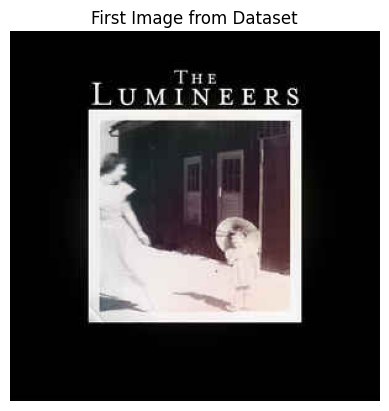

In [7]:
from PIL import Image
import io
import matplotlib.pyplot as plt

# Extract the bytes of the first image
image_data = df.iloc[0]['image']['bytes']

# Convert the byte data into an image
image = Image.open(io.BytesIO(image_data))

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Remove axes for better visualization
plt.title("First Image from Dataset")
plt.show()



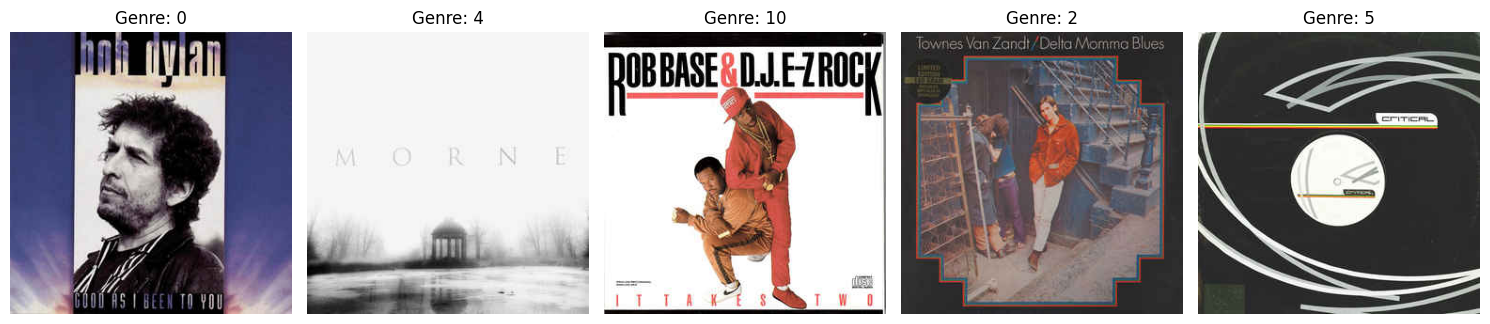

In [8]:
import matplotlib.pyplot as plt

randoms = [234, 4400, 10110, 2220, 5550]



# Create subplots (1 row, 5 columns)
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # Adjust figsize for better display

for ax, i in zip(axes, randoms):
    row = df.iloc[i]
    image_data = row['image']['bytes']
    label = row['label']

    # Decode the image
    image = Image.open(io.BytesIO(image_data))

    # Plot the image in the corresponding subplot
    ax.imshow(image)
    ax.set_title(f"Genre: {label}")  # Use mapping if needed
    ax.axis('off')  # Remove axes for a cleaner look

# Adjust layout and display the plot
plt.tight_layout()
plt.show()



In [9]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import io
import pandas as pd
from sklearn.model_selection import train_test_split

class MyDataset(Dataset):
    def __init__(self, dataframe):
        """
        Initialize the dataset with the DataFrame and apply transforms.
        """
        self.dataframe = dataframe
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        """
        Retrieve an image and its label by decoding the image bytes.
        """
        # Decode the image from bytes
        image_bytes = self.dataframe.iloc[index]['image']['bytes']
        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
        image = self.transform(image)

        # Get the label
        label = self.dataframe.iloc[index]['label']

        return image, label

    def __len__(self):
        """
        Return the size of the dataset.
        """
        return len(self.dataframe)

# Splitting the dataset into train, validation, and test
labels_df = df  # Assuming `df` contains your DataFrame

train_df, val_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['label'])
val_df, test_df = train_test_split(val_df, test_size=0.5, stratify=val_df['label'])

# Creating dataset and dataloaders
train_data = MyDataset(train_df)
val_data = MyDataset(val_df)
test_data = MyDataset(test_df)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Mini-batch train dataset
mb_train_dataset = MyDataset(train_df)  # For mini-batch training


In [22]:
#PRIMERO DE FELPA
class CNN:
    def __init__(self, outputs):
        model = resnet50(weights=ResNet50_Weights.DEFAULT)

        for i in model.parameters():
            i.requires_grad = False

        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, outputs)
        )
        self.model = model

        if torch.cuda.is_available():
            self.device = "cuda"
        else:
            self.device = "cpu"
        self.model.to(self.device)
        self.parameters = model.parameters()


    def train(self, train_loader, val_loader, loss_fn, optimizer, epochs=10, patience=3):

        best_val_accuracy = 0.0
        early_stop_counter = 0

        for i in tqdm(range(0, epochs)):
            self.model.train()
            train_loss, correct_train = 0, 0
            for x, y in tqdm(train_loader):
                print(y)
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(x)
                loss = loss_fn(outputs, y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                correct_train += (outputs.argmax(1) == y).sum().item()

            train_accuracy = correct_train/len(train_loader.dataset)

            print(f"Epoch {i+1}, Training Loss: {train_loss / len(train_loader.dataset)}")
            print(f"Epoch {i+1}, Training Accuracy: {train_accuracy}")

            self.model.eval()
            val_loss, correct_val = 0, 0
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(self.device), y.to(self.device)
                    outputs = self.model(x)
                    loss = loss_fn(outputs, y)
                    val_loss += loss.item()
                    correct_val += (outputs.argmax(1) == y).sum().item()

            val_accuracy = correct_val/len(train_loader.dataset)
            print(f"Epoch {i+1}, Validation Loss: {val_loss / len(val_loader)}")
            print(f"Epoch {i+1}, Validation Accuracy {val_accuracy}")

            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                print(f"No improvement for {early_stop_counter} epoch(s)")

            if early_stop_counter == patience:
                print(f"Early stopping triggered after {early_stop_counter} epochs")
                break

    def train_with_mini_batch(self, train_data, val_loader, loss_fn, optimizer, batch_size=32, epochs=10, patience=3, save_interval=1):
        history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

        best_val_acc = 0.0
        early_stop_counter = 0

        for epoch in tqdm(range(0, epochs)):
            train_loss, correct_train = 0, 0

            indices = np.random.choice(len(train_data), size=batch_size, replace=False)
            batch_samples = [train_data[i] for i in indices]
            x, y = zip(*batch_samples)
            x = torch.stack([torch.tensor(img, dtype=torch.float32) for img in x])
            y = torch.tensor(y, dtype=torch.long)

            self.model.train()
            x, y = x.to(self.device), y.to(self.device)
            optimizer.zero_grad()
            outputs = self.model(x)
            loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            correct_train += (outputs.argmax(1) == y).sum().item()

            train_accuracy = correct_train/batch_size

            history["train_loss"].append(train_loss/len(train_loader.dataset))
            history["train_acc"].append(train_accuracy)

            print()
            print(f"Epoch {epoch+1}, Training Loss: {train_loss/len(train_loader.dataset)}")
            print(f"Epoch {epoch+1}, Training Accuracy: {train_accuracy}")



            self.model.eval()
            val_loss, correct_val = 0, 0
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(self.device), y.to(self.device)
                    outputs = self.model(x)
                    loss = loss_fn(outputs, y)
                    val_loss += loss.item()
                    correct_val += (outputs.argmax(1) == y).sum().item()

            val_accuracy = correct_val/len(train_loader.dataset)

            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_accuracy)

            print(f"Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader)}")
            print(f"Epoch {epoch+1}, Validation Accuracy {val_accuracy}")


                    # Save model every save_interval epochs
            if (epoch + 1) % save_interval == 0:
                model_filename = f"ResNet_{epoch+1}epochs_NEWDATA.pth"
                torch.save({'model_state_dict': self.model.state_dict()}, model_filename)
                print(f"Model saved as {model_filename}")

            # Early stopping logic
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                early_stop_counter = 0  # Reset counter if improvement
            else:
                early_stop_counter += 1
                print(f"No improvement for {early_stop_counter} epoch(s).")

            if early_stop_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

        return history


    def forward(self, image):
        input_tensor = transforms.ToTensor()(image).unsqueeze(0)
        self.model.eval()
        input_tensor = input_tensor.to(self.device)

        with torch.no_grad():
            output = self.model(input_tensor)

        prediction = torch.argmax(output, dim=1).item()

        return prediction


    def get_parameters(self):
        return self.parameters

    def save(self):
        model_filename = f"resnet50_model"
        torch.save({'model_state_dict': self.model.state_dict()}, model_filename)

    def confusion_mat(self , data=val_loader):
        self.model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in data:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                all_preds.append(outputs.argmax(1).cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)


        f1 = f1_score(all_labels, all_preds, average='weighted')
        print(f"F1 Score: {f1:.4f}")
        print(classification_report(all_labels, all_preds))


        conf_mat = confusion_matrix(all_labels, all_preds)

        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()



def prepare_cnn(outputs):

    model = resnet50(weights=ResNet50_Weights.DEFAULT)

    for i in model.parameters():
        i.requires_grad = False

    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, outputs),
        nn.Softmax(dim=1)
    )

    return model

In [12]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, metric):
        if self.best_score is None or metric > self.best_score + self.delta:
            self.best_score = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN(outputs=20)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.get_parameters(), lr=0.001)

# model.train(train_loader, val_loader, loss_fn, optimizer, epochs=10)
history = model.train_with_mini_batch(mb_train_dataset, val_loader, loss_fn, optimizer, batch_size=32, epochs=30, patience=3, save_interval=1)

#model.save()

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-22-cb96fbeda249>:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.stack([torch.tensor(img, dtype=torch.float32) for img in x])



Epoch 1, Training Loss: 0.00018668991327285768
Epoch 1, Training Accuracy: 0.0625
Epoch 1, Validation Loss: 3.008464143389747
Epoch 1, Validation Accuracy 0.0078125


  3%|▎         | 1/30 [00:09<04:36,  9.54s/it]

Model saved as ResNet_1epochs_NEWDATA.pth

Epoch 2, Training Loss: 0.00018478921055793763
Epoch 2, Training Accuracy: 0.09375
Epoch 2, Validation Loss: 3.0101209897843617
Epoch 2, Validation Accuracy 0.00875


  7%|▋         | 2/30 [00:19<04:27,  9.54s/it]

Model saved as ResNet_2epochs_NEWDATA.pth

Epoch 3, Training Loss: 0.00018961715698242188
Epoch 3, Training Accuracy: 0.0625
Epoch 3, Validation Loss: 3.0078089842720637
Epoch 3, Validation Accuracy 0.0085625


 10%|█         | 3/30 [00:28<04:17,  9.52s/it]

Model saved as ResNet_3epochs_NEWDATA.pth
No improvement for 1 epoch(s).

Epoch 4, Training Loss: 0.00018936850130558014
Epoch 4, Training Accuracy: 0.0625
Epoch 4, Validation Loss: 3.0011252372983903
Epoch 4, Validation Accuracy 0.008625


 13%|█▎        | 4/30 [00:38<04:08,  9.57s/it]

Model saved as ResNet_4epochs_NEWDATA.pth
No improvement for 2 epoch(s).

Epoch 5, Training Loss: 0.00018649104237556457
Epoch 5, Training Accuracy: 0.0625
Epoch 5, Validation Loss: 2.993572613549611
Epoch 5, Validation Accuracy 0.009375


 17%|█▋        | 5/30 [00:47<03:59,  9.60s/it]

Model saved as ResNet_5epochs_NEWDATA.pth

Epoch 6, Training Loss: 0.00018879047036170958
Epoch 6, Training Accuracy: 0.0
Epoch 6, Validation Loss: 2.985558721754286
Epoch 6, Validation Accuracy 0.010125


 20%|██        | 6/30 [00:57<03:50,  9.61s/it]

Model saved as ResNet_6epochs_NEWDATA.pth

Epoch 7, Training Loss: 0.00018126879632472993
Epoch 7, Training Accuracy: 0.0625
Epoch 7, Validation Loss: 2.9797292209806896
Epoch 7, Validation Accuracy 0.0108125


 23%|██▎       | 7/30 [01:07<03:41,  9.64s/it]

Model saved as ResNet_7epochs_NEWDATA.pth

Epoch 8, Training Loss: 0.00018636834621429444
Epoch 8, Training Accuracy: 0.09375
Epoch 8, Validation Loss: 2.9715608188084195
Epoch 8, Validation Accuracy 0.0115


 27%|██▋       | 8/30 [01:16<03:31,  9.64s/it]

Model saved as ResNet_8epochs_NEWDATA.pth

Epoch 9, Training Loss: 0.00018433642387390137
Epoch 9, Training Accuracy: 0.125
Epoch 9, Validation Loss: 2.963860477719988
Epoch 9, Validation Accuracy 0.0124375


 30%|███       | 9/30 [01:26<03:22,  9.64s/it]

Model saved as ResNet_9epochs_NEWDATA.pth

Epoch 10, Training Loss: 0.00018737854063510895
Epoch 10, Training Accuracy: 0.09375
Epoch 10, Validation Loss: 2.956062869420127
Epoch 10, Validation Accuracy 0.0125625


 33%|███▎      | 10/30 [01:36<03:12,  9.64s/it]

Model saved as ResNet_10epochs_NEWDATA.pth

Epoch 11, Training Loss: 0.00019002942740917205
Epoch 11, Training Accuracy: 0.0


 37%|███▋      | 11/30 [01:45<03:01,  9.57s/it]

Epoch 11, Validation Loss: 2.9471234594072615
Epoch 11, Validation Accuracy 0.013375
Model saved as ResNet_11epochs_NEWDATA.pth

Epoch 12, Training Loss: 0.0001862402856349945
Epoch 12, Training Accuracy: 0.0625


 40%|████      | 12/30 [01:54<02:51,  9.51s/it]

Epoch 12, Validation Loss: 2.938800531720358
Epoch 12, Validation Accuracy 0.0130625
Model saved as ResNet_12epochs_NEWDATA.pth
No improvement for 1 epoch(s).

Epoch 13, Training Loss: 0.00018559500575065612
Epoch 13, Training Accuracy: 0.0625


 43%|████▎     | 13/30 [02:04<02:40,  9.46s/it]

Epoch 13, Validation Loss: 2.9310245476071795
Epoch 13, Validation Accuracy 0.01375
Model saved as ResNet_13epochs_NEWDATA.pth

Epoch 14, Training Loss: 0.00018698258697986603
Epoch 14, Training Accuracy: 0.0625


 47%|████▋     | 14/30 [02:13<02:30,  9.42s/it]

Epoch 14, Validation Loss: 2.9238561070154585
Epoch 14, Validation Accuracy 0.0126875
Model saved as ResNet_14epochs_NEWDATA.pth
No improvement for 1 epoch(s).

Epoch 15, Training Loss: 0.0001892891824245453
Epoch 15, Training Accuracy: 0.03125


 50%|█████     | 15/30 [02:22<02:21,  9.40s/it]

Epoch 15, Validation Loss: 2.9156701337723505
Epoch 15, Validation Accuracy 0.0133125
Model saved as ResNet_15epochs_NEWDATA.pth
No improvement for 2 epoch(s).

Epoch 16, Training Loss: 0.0001786985397338867
Epoch 16, Training Accuracy: 0.125


 50%|█████     | 15/30 [02:32<02:32, 10.16s/it]

Epoch 16, Validation Loss: 2.909017184424022
Epoch 16, Validation Accuracy 0.013625
Model saved as ResNet_16epochs_NEWDATA.pth
No improvement for 3 epoch(s).
Early stopping triggered after 16 epochs.


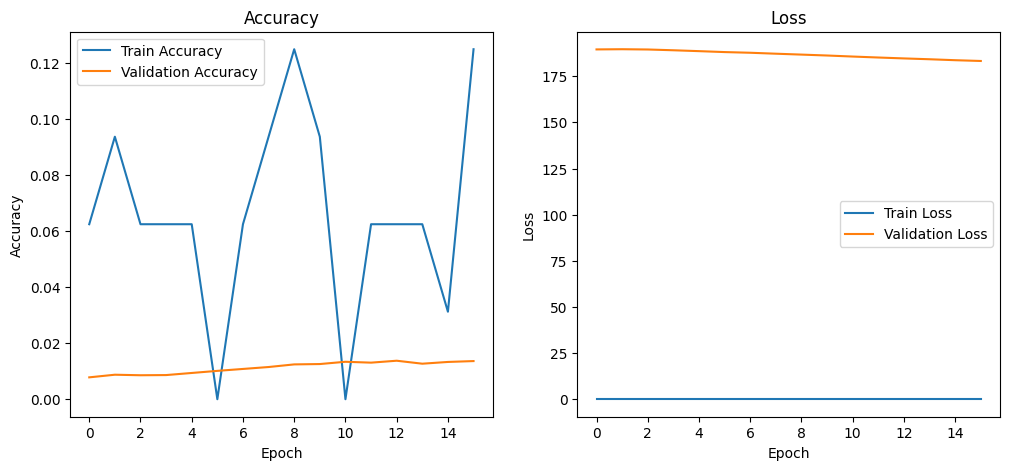

In [27]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

F1 Score: 0.0874
              precision    recall  f1-score   support

           0       0.12      0.01      0.02       800
           1       0.47      0.12      0.19       800
           2       0.19      0.15      0.17       800
           3       0.52      0.03      0.06       800
           4       0.25      0.08      0.12       800
           5       0.12      0.13      0.12       800
           6       0.12      0.03      0.05       800
           7       0.06      0.01      0.01       800
           8       0.17      0.03      0.05       800
           9       0.09      0.71      0.15       800
          10       0.11      0.13      0.12       800
          11       0.15      0.04      0.06       800
          12       0.33      0.00      0.00       800
          13       0.11      0.09      0.10       800
          14       0.08      0.16      0.11       800
          15       0.07      0.13      0.09       800
          16       0.00      0.00      0.00       800
          

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


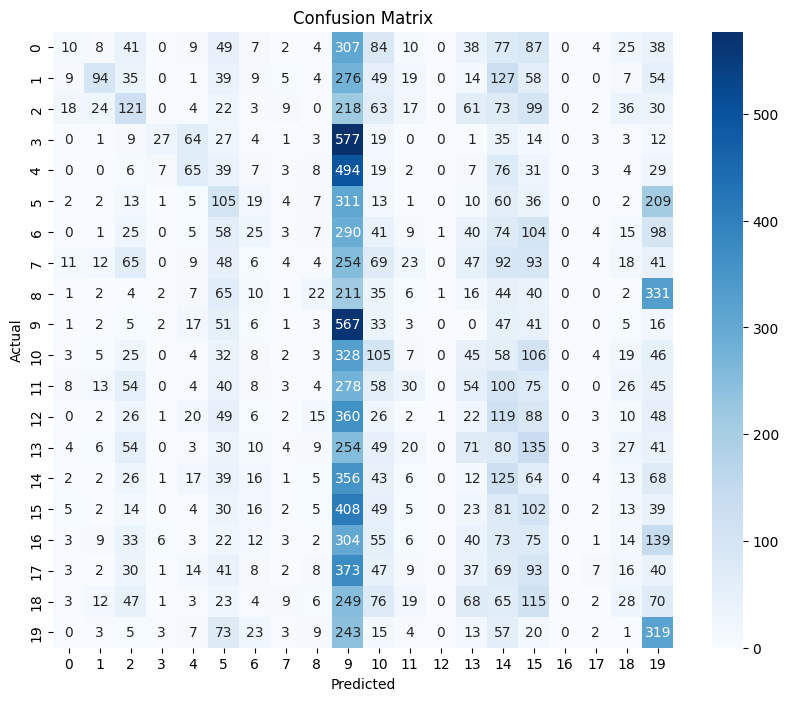

In [28]:
model.confusion_mat(train_loader)

F1 Score: 0.0772
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.18      0.03      0.05       100
           2       0.17      0.12      0.14       100
           3       0.25      0.01      0.02       100
           4       0.43      0.16      0.23       100
           5       0.14      0.16      0.15       100
           6       0.12      0.02      0.03       100
           7       0.20      0.01      0.02       100
           8       0.07      0.01      0.02       100
           9       0.08      0.67      0.14       100
          10       0.04      0.05      0.05       100
          11       0.07      0.02      0.03       100
          12       0.00      0.00      0.00       100
          13       0.10      0.07      0.08       100
          14       0.06      0.13      0.09       100
          15       0.08      0.15      0.11       100
          16       0.00      0.00      0.00       100
          

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


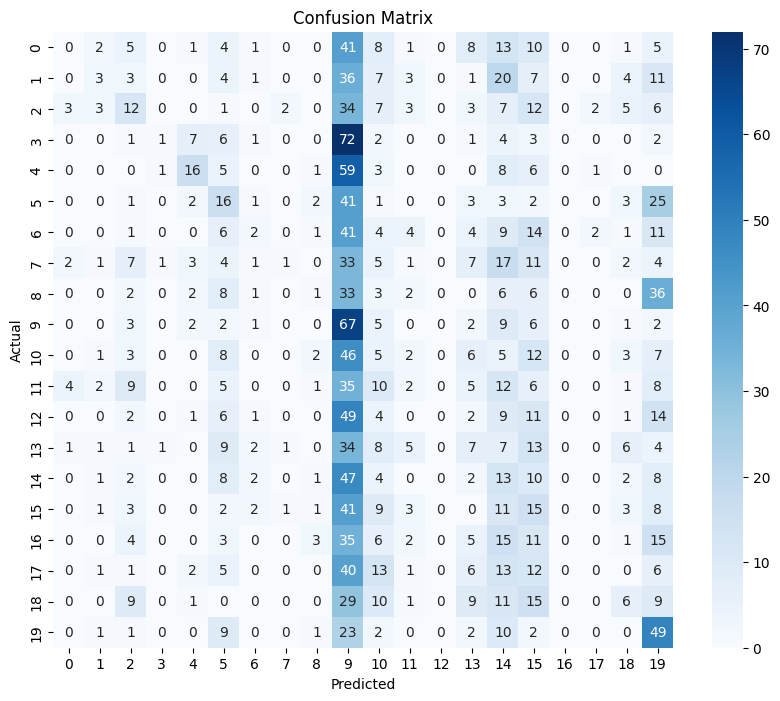

In [29]:
model.confusion_mat()

F1 Score: 0.0766
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.38      0.08      0.13       100
           2       0.20      0.18      0.19       100
           3       0.27      0.03      0.05       100
           4       0.22      0.08      0.12       100
           5       0.04      0.04      0.04       100
           6       0.12      0.03      0.05       100
           7       0.00      0.00      0.00       100
           8       0.14      0.01      0.02       100
           9       0.08      0.62      0.14       100
          10       0.14      0.19      0.16       100
          11       0.06      0.02      0.03       100
          12       0.00      0.00      0.00       100
          13       0.13      0.10      0.11       100
          14       0.06      0.12      0.08       100
          15       0.05      0.10      0.07       100
          16       0.00      0.00      0.00       100
          

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


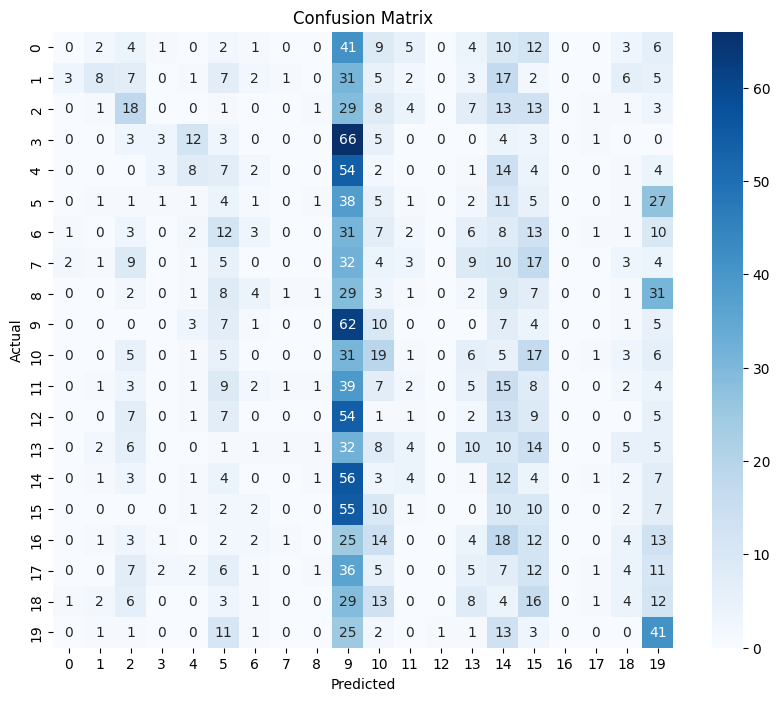

In [30]:
model.confusion_mat(test_loader)